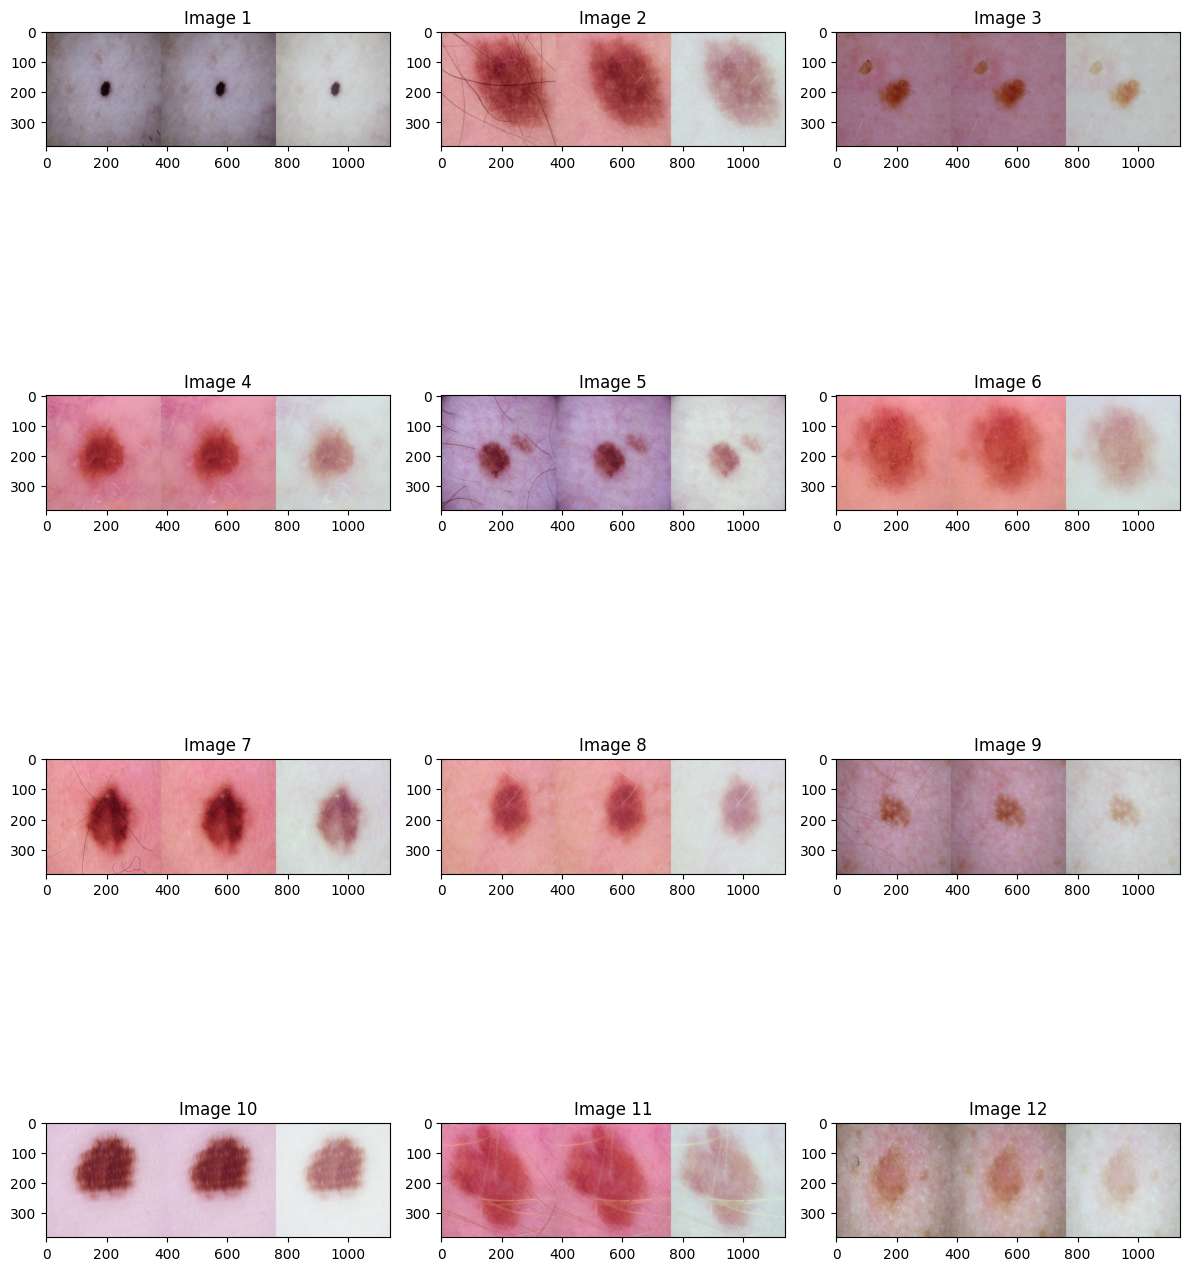

In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt  # Optional, for displaying images

def preprocess_image(image_path, target_size=(380, 380)):
    # Load the image
    original_image = cv2.imread(image_path)

    # Resize the original image to the target size
    resized_original = cv2.resize(original_image, target_size)

    # Convert the resized image to grayscale
    gray_scale = cv2.cvtColor(resized_original, cv2.COLOR_BGR2GRAY)

    # Kernel for the morphological filtering
    kernel = cv2.getStructuringElement(1, (17, 17))

    # Perform the blackHat filtering on the grayscale image to find the hair contours
    blackhat = cv2.morphologyEx(gray_scale, cv2.MORPH_BLACKHAT, kernel)

    # Intensify the hair contours in preparation for inpainting
    ret, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # Inpaint the resized original image depending on the mask
    inpainted_image = cv2.inpaint(resized_original, threshold, 1, cv2.INPAINT_TELEA)

    # Convert the inpainted image back to BGR color space
    resized_image_bgr = inpainted_image  # No need for cv2.cvtColor here

    return resized_original, resized_image_bgr

def color_constancy(img, power=6, gamma=2.2):
    """
    Parameters
    ----------
    img: 3D numpy array
        The original image with format of (h, w, c)
    power: int
        The degree of norm, 6 is used in the reference paper
    gamma: float
        The value of gamma correction, 2.2 is used in the reference paper
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256, 1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0, 1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    return img.astype(img_dtype)

# Directory path
directory_path = "/kaggle/input/datasetskinlesion/Dataset/Dataset/NEV"

# Get the list of files in the directory
files = os.listdir(directory_path)

# Select the first 12 image files (you can modify this based on your needs)
selected_files = files[:12]

# Create a 4x3 subplot grid
fig, axes = plt.subplots(4, 3, figsize=(12, 16))

# Iterate over the selected files
for i, file_name in enumerate(selected_files):
    # Preprocess the image
    image_path = os.path.join(directory_path, file_name)
    original_img, preprocessed_img = preprocess_image(image_path)

    # Apply color constancy
    result_img = color_constancy(preprocessed_img)

    # Display the original, preprocessed, and result images in the subplot
    axes[i // 3, i % 3].imshow(np.hstack([cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB),
                                          cv2.cvtColor(preprocessed_img, cv2.COLOR_BGR2RGB),
                                          cv2.cvtColor(result_img.astype('uint8'), cv2.COLOR_BGR2RGB)]))
    axes[i // 3, i % 3].set_title(f'Image {i + 1}')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [7]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools

# Function to preprocess and resize an image
def preprocess_image(image_path, input_size=(128, 128)):
    original_image = cv2.imread(image_path)
    resized_image = cv2.resize(original_image, input_size)
    # Add any additional preprocessing steps if needed
    return resized_image

# Load data
mel_folder = '/kaggle/input/datasetskinlesion/Processedg2.2/Processedg2.2/MEL'
nev_folder = '/kaggle/input/datasetskinlesion/Processedg2.2/Processedg2.2/NEV'

# Load all images
mel_images_all = [preprocess_image(os.path.join(mel_folder, filename)) for filename in os.listdir(mel_folder)]
nev_images_all = [preprocess_image(os.path.join(nev_folder, filename)) for filename in os.listdir(nev_folder)]

# Combine and shuffle images and labels
all_images = mel_images_all + nev_images_all
all_labels = [1] * len(mel_images_all) + [0] * len(nev_images_all)

# Calculate class weights manually
unique_classes, class_counts = np.unique(all_labels, return_counts=True)
total_samples = len(all_labels)
class_weights = total_samples / (len(unique_classes) * class_counts)
class_weight_dict = dict(zip(unique_classes, class_weights))

In [8]:
# Load and augment data without resizing again
def load_data_and_augment(images, labels):
    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )

    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):
        for _ in range(5):  # Augment each image 5 times
            augmented_image = datagen.random_transform(image)
            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    return augmented_images, augmented_labels

# Combine and shuffle images and labels without resizing again
augmented_images, augmented_labels = load_data_and_augment(all_images, all_labels)

all_images_augmented = np.array(augmented_images)
all_labels_augmented = np.array(augmented_labels)

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define K-Fold validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define Modified EfficientNetB4 model
def build_model(input_shape=(128, 128, 3)):
    base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=input_shape)
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

# Initialize metrics 
precision_scores = []
recall_scores = []
accuracy_scores = []
f1_scores = []
roc_auc_scores = []


# Initialize predictions and true labels for ROC curve and confusion matrix
all_true_labels = []
all_predictions = []

# Perform K-Fold validation
for train_index, test_index in kfold.split(all_images, all_labels):
    X_train, X_test = all_images_augmented[train_index], all_images_augmented[test_index]
    y_train, y_test = all_labels_augmented[train_index], all_labels_augmented[test_index]

    model = build_model()

    # Train the model with class weights and learning rate scheduler
    history = model.fit(X_train, y_train, epochs=16, batch_size=32, 
                        validation_data=(X_test, y_test), 
                        class_weight=class_weight_dict,
                        callbacks=[LearningRateScheduler(lr_scheduler)])

    # Evaluate the model on the test set
    y_pred_prob = model.predict(X_test)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
   
    precision_scores.append(precision_score(y_test, y_pred_binary))
    recall_scores.append(recall_score(y_test, y_pred_binary))
    accuracy_scores.append(accuracy_score(y_test, y_pred_binary))
    f1_scores.append(f1_score(y_test, y_pred_binary))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_prob))

# Print average metrics 
print(f'Average Precision: {np.mean(precision_scores)}')
print(f'Average Recall: {np.mean(recall_scores)}')
print(f'Average Accuracy: {np.mean(accuracy_scores)}')
print(f'Average F1 Score: {np.mean(f1_scores)}')
print(f'Average ROC AUC Score: {np.mean(roc_auc_scores)}')


Epoch 1/16


2024-01-30 15:20:48.320823: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


196/196 [==============================] - 126s 243ms/step - loss: 1.0675 - accuracy: 0.7745 - val_loss: 0.7358 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 2/16
196/196 [==============================] - 44s 224ms/step - loss: 0.5494 - accuracy: 0.7945 - val_loss: 1.2841 - val_accuracy: 0.5192 - lr: 0.0010
Epoch 3/16
196/196 [==============================] - 44s 227ms/step - loss: 0.4673 - accuracy: 0.7969 - val_loss: 0.8051 - val_accuracy: 0.7685 - lr: 0.0010
Epoch 4/16
196/196 [==============================] - 45s 228ms/step - loss: 0.3628 - accuracy: 0.8375 - val_loss: 0.4176 - val_accuracy: 0.8478 - lr: 0.0010
Epoch 5/16
196/196 [==============================] - 45s 230ms/step - loss: 0.3328 - accuracy: 0.8567 - val_loss: 0.4247 - val_accuracy: 0.8555 - lr: 0.0010
Epoch 6/16
196/196 [==============================] - 45s 230ms/step - loss: 0.2954 - accuracy: 0.8705 - val_loss: 0.3432 - val_accuracy: 0.8753 - lr: 9.0484e-04
Epoch 7/16
196/196 [==============================] - 45s 

2024-01-30 15:34:24.956432: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


196/196 [==============================] - 124s 242ms/step - loss: 1.0245 - accuracy: 0.7696 - val_loss: 0.9400 - val_accuracy: 0.7724 - lr: 0.0010
Epoch 2/16
196/196 [==============================] - 45s 228ms/step - loss: 0.5174 - accuracy: 0.8097 - val_loss: 0.4354 - val_accuracy: 0.8485 - lr: 0.0010
Epoch 3/16
196/196 [==============================] - 45s 229ms/step - loss: 0.3813 - accuracy: 0.8358 - val_loss: 0.4973 - val_accuracy: 0.8248 - lr: 0.0010
Epoch 4/16
196/196 [==============================] - 45s 230ms/step - loss: 0.3567 - accuracy: 0.8487 - val_loss: 0.5801 - val_accuracy: 0.8274 - lr: 0.0010
Epoch 5/16
196/196 [==============================] - 45s 231ms/step - loss: 0.3599 - accuracy: 0.8471 - val_loss: 3.5978 - val_accuracy: 0.8721 - lr: 0.0010
Epoch 6/16
196/196 [==============================] - 45s 232ms/step - loss: 0.2720 - accuracy: 0.8769 - val_loss: 0.3224 - val_accuracy: 0.8958 - lr: 9.0484e-04
Epoch 7/16
196/196 [==============================] - 45s 

2024-01-30 15:48:02.449449: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


196/196 [==============================] - 124s 241ms/step - loss: 1.0515 - accuracy: 0.7611 - val_loss: 0.7031 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 2/16
196/196 [==============================] - 45s 230ms/step - loss: 0.5667 - accuracy: 0.7803 - val_loss: 0.9420 - val_accuracy: 0.7858 - lr: 0.0010
Epoch 3/16
196/196 [==============================] - 46s 234ms/step - loss: 0.4696 - accuracy: 0.8033 - val_loss: 0.6264 - val_accuracy: 0.7852 - lr: 0.0010
Epoch 4/16
196/196 [==============================] - 46s 232ms/step - loss: 0.4182 - accuracy: 0.8256 - val_loss: 0.4696 - val_accuracy: 0.8446 - lr: 0.0010
Epoch 5/16
196/196 [==============================] - 46s 233ms/step - loss: 0.3267 - accuracy: 0.8510 - val_loss: 0.9524 - val_accuracy: 0.8223 - lr: 0.0010
Epoch 6/16
196/196 [==============================] - 46s 232ms/step - loss: 0.2678 - accuracy: 0.8804 - val_loss: 0.3890 - val_accuracy: 0.8638 - lr: 9.0484e-04
Epoch 7/16
196/196 [==============================] - 46s 

2024-01-30 16:01:43.014221: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


196/196 [==============================] - 127s 252ms/step - loss: 1.0730 - accuracy: 0.7768 - val_loss: 0.6365 - val_accuracy: 0.7761 - lr: 0.0010
Epoch 2/16
196/196 [==============================] - 46s 233ms/step - loss: 0.5351 - accuracy: 0.7890 - val_loss: 0.4317 - val_accuracy: 0.8138 - lr: 0.0010
Epoch 3/16
196/196 [==============================] - 46s 234ms/step - loss: 0.4400 - accuracy: 0.8131 - val_loss: 0.7046 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 4/16
196/196 [==============================] - 46s 233ms/step - loss: 0.3335 - accuracy: 0.8504 - val_loss: 0.3069 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 5/16
196/196 [==============================] - 46s 234ms/step - loss: 0.2659 - accuracy: 0.8804 - val_loss: 0.2889 - val_accuracy: 0.9066 - lr: 0.0010
Epoch 6/16
196/196 [==============================] - 46s 233ms/step - loss: 0.2118 - accuracy: 0.9092 - val_loss: 0.8647 - val_accuracy: 0.7498 - lr: 9.0484e-04
Epoch 7/16
196/196 [==============================] - 46s 

2024-01-30 16:15:26.961100: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


196/196 [==============================] - 126s 242ms/step - loss: 1.1003 - accuracy: 0.7720 - val_loss: 1.4431 - val_accuracy: 0.7185 - lr: 0.0010
Epoch 2/16
196/196 [==============================] - 45s 228ms/step - loss: 0.5145 - accuracy: 0.8050 - val_loss: 1.0697 - val_accuracy: 0.7537 - lr: 0.0010
Epoch 3/16
196/196 [==============================] - 45s 229ms/step - loss: 0.4946 - accuracy: 0.8030 - val_loss: 0.7523 - val_accuracy: 0.7639 - lr: 0.0010
Epoch 4/16
196/196 [==============================] - 45s 230ms/step - loss: 0.4290 - accuracy: 0.8297 - val_loss: 0.4211 - val_accuracy: 0.8791 - lr: 0.0010
Epoch 5/16
196/196 [==============================] - 45s 231ms/step - loss: 0.3244 - accuracy: 0.8576 - val_loss: 0.3391 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 6/16
196/196 [==============================] - 45s 231ms/step - loss: 0.2370 - accuracy: 0.8948 - val_loss: 0.5352 - val_accuracy: 0.8413 - lr: 9.0484e-04
Epoch 7/16
196/196 [==============================] - 45s 

Normalized confusion matrix
[[0.88691796 0.11308204]
 [0.00809353 0.99190647]]


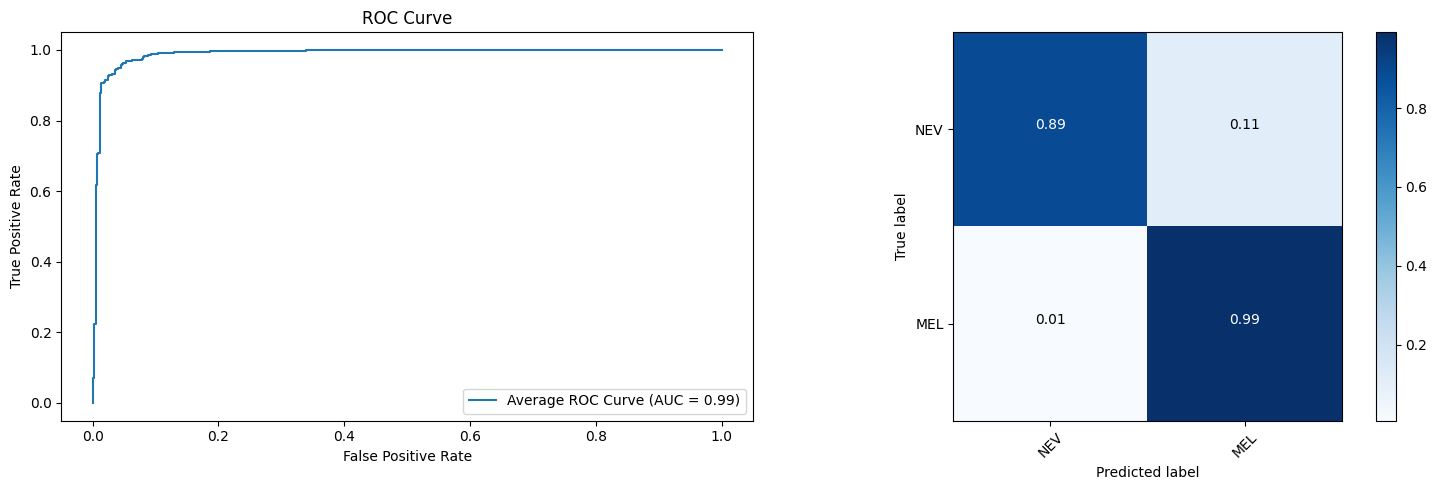

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Store true labels and predictions for ROC curve and confusion matrix
all_true_labels.extend(y_test)
all_predictions.extend(y_pred_prob)

# Plot ROC curve and confusion matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(all_true_labels, all_predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Average ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plot_confusion_matrix(all_true_labels, (np.array(all_predictions) > 0.5).astype(int), classes=['NEV', 'MEL'])
plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Store true labels and predictions for ROC curve and confusion matrix
all_true_labels.extend(y_test)
all_predictions.extend(y_pred_prob)

# Plot ROC curve and confusion matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(all_true_labels, all_predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Average ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plot_confusion_matrix(all_true_labels, (np.array(all_predictions) > 0.5).astype(int), classes=['NEV', 'MEL'])
plt.show()